In [33]:
import pandas as pd
import networkx as nx
pd.options.display.max_colwidth= 500

In [2]:
import json
with open('/Users/patrick.collard/Downloads/GameFeed.json') as f:
    gameJson = json.load(f)

In [3]:
[x for x,y in gameJson.items()]

['termsOfUse',
 'id',
 'state',
 'name',
 'numberOfTurns',
 'lastTurnTime',
 'players',
 'map']

In [4]:
territoryDF = pd.DataFrame(gameJson['map']['territories'])
territoryDF['id'] = territoryDF['id'].astype('int')

In [5]:
territoryDF.head()

,name,id,connectedTo
0,Alaskan Interior West,0,"[3315, 3316, 3317, 3318, 3319, 3322, 3326]"
1,Novgorod,4096,"[4097, 4098, 5002, 4099, 4108, 4109]"
2,Southeastern Uruguay,1,"[4, 197, 2]"
3,Southern Tver,4097,"[4096, 4098, 4108, 4110, 4095]"
4,Northeastern Uruguay,2,"[1, 3, 4, 197]"


In [6]:
bonusDF = pd.DataFrame(gameJson['map']['bonuses'])
bonusDF['value'] = bonusDF.value.apply(int)
bonusDF['size'] = bonusDF.territoryIDs.apply(len)
bonusDF['valueRatio'] = bonusDF.apply(lambda x:x['value']/x['size'],axis=1)

In [7]:
bonusDF.sort_values('valueRatio',ascending=False).head()

,id,name,value,territoryIDs,size,valueRatio
0,1,French Guyana,2,"[45, 46]",2,1.0
180,184,New Hampshire,1,[692],1,1.0
167,171,Gabon,7,"[614, 615, 613, 616, 619, 617, 618]",7,1.0
168,172,Republic of the Congo,7,"[620, 621, 622, 623, 628, 624, 627]",7,1.0
476,484,Wallis and Futuna,1,[3037],1,1.0


In [8]:
from opencage.geocoder import OpenCageGeocode

key = 'd5b66cd9769f4186a3027677126283de'
geocoder = OpenCageGeocode(key)

records = []
with open('geo.txt') as f:
    country = True
    line = f.readline()
    buff = ''
    while line:
        if country:
            buff = line
            country = False
        else:
            records.append((buff,line))
            country = True
        line =  f.readline()

def get_lat_long(query:str) -> str:
    try:
        results = geocoder.geocode(query)
        #save results
        with open("geo.txt", "a+") as f:
            f.write(query)
            f.write('\n')
            f.write(str(results))
            f.write('\n')
            return results[0]['geometry']
    except:
        return ''

In [9]:
#bonusDF[['lat','long']] = bonusDF.name.apply(lambda x:pd.Series(get_lat_long(x)))

In [10]:
latLongDF = pd.DataFrame([(x[0],eval(x[1])[0]['geometry']) for x in records if len(x) == 2 and len(eval(x[1]))>0],columns=['name','lat_long'])
latLongDF['name'] = latLongDF['name'].apply(lambda x:x[:-1])
latLongDF[['lat','lng']] = latLongDF.lat_long.apply(pd.Series)

In [11]:
latLongDF.head()

,name,lat_long,lat,lng
0,French Guyana,"{'lat': 6.8245065, 'lng': -58.1345775}",6.824507,-58.134577
1,Suriname,"{'lat': 4.1413025, 'lng': -56.0771187}",4.141303,-56.077119
2,Guyana,"{'lat': 4.8417097, 'lng': -58.6416891}",4.841710,-58.641689
3,Western Venezuela,"{'lat': 10.4841089, 'lng': -66.8546319}",10.484109,-66.854632
4,Eastern Venezuela,"{'lat': 45.4265555, 'lng': -75.6730347}",45.426555,-75.673035


In [12]:
bonusDF = pd.merge(bonusDF,latLongDF,on=['name'])

In [13]:
bonusDF.head()

,id,name,value,territoryIDs,size,valueRatio,lat_long,lat,lng
0,1,French Guyana,2,"[45, 46]",2,1.000000,"{'lat': 6.8245065, 'lng': -58.1345775}",6.824507,-58.134577
1,2,Suriname,3,"[49, 47, 48]",3,1.000000,"{'lat': 4.1413025, 'lng': -56.0771187}",4.141303,-56.077119
2,3,Guyana,3,"[50, 51, 52]",3,1.000000,"{'lat': 4.8417097, 'lng': -58.6416891}",4.841710,-58.641689
3,4,Western Venezuela,6,"[63, 62, 64, 65, 66, 67, 212]",7,0.857143,"{'lat': 10.4841089, 'lng': -66.8546319}",10.484109,-66.854632
4,5,Eastern Venezuela,3,"[61, 59, 58, 60]",4,0.750000,"{'lat': 45.4265555, 'lng': -75.6730347}",45.426555,-75.673035


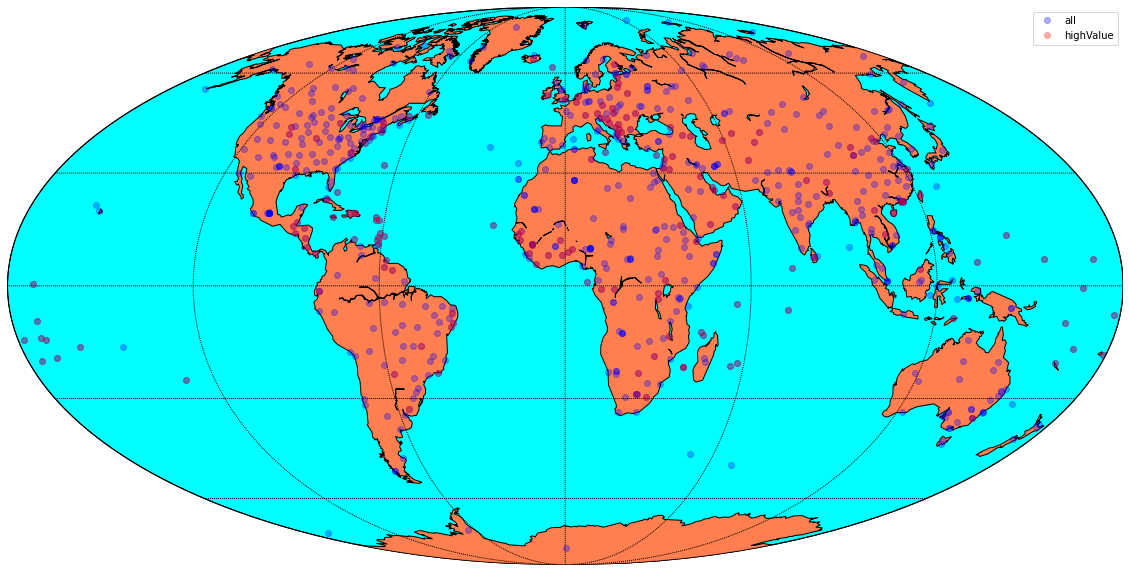

In [14]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20,12))
m = Basemap(projection='moll',lon_0=0,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
m.drawmapboundary(fill_color='aqua')
xpt,ypt = m(bonusDF.lng.to_list(),bonusDF.lat.to_list())
m.plot(xpt,ypt,'bo',alpha=0.3,label='all')  # plot a blue dot there
xpt,ypt = m(bonusDF[bonusDF['valueRatio']>=1].lng.to_list(),bonusDF[bonusDF['valueRatio']>=1].lat.to_list())
m.plot(xpt,ypt,'ro',alpha=0.3,label='highValue')  # plot a blue dot there
plt.legend()
plt.show()

In [15]:
highValueSets = {}
for size,grp in bonusDF[(bonusDF['valueRatio']>=1)].groupby('size'):
    highValueSets[size] = set([item for sublist in grp.territoryIDs for item in sublist])

In [16]:
territoryDF[territoryDF.id.isin(highValueSets[1])].head()

,name,id,connectedTo
163,Paraiba,125,"[124, 140, 205, 126, 127]"
166,Alagoas,128,"[129, 164, 126, 127]"
167,Sergipe,129,"[128, 163]"
203,Federal District,171,"[168, 175]"
213,Rio de Janeiro,181,"[185, 172, 173, 182]"


In [54]:
bonusPivot = bonusDF[['name','value','territoryIDs']].explode('territoryIDs')\
   .groupby('territoryIDs',as_index=False)['name','value']\
   .agg(lambda x: list(x))\
   .rename(columns={'territoryIDs':'id', 'name': 'bonusNames', 'value': 'bonusValues'})

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [55]:
bonusPivot.head()

,id,bonusNames,bonusValues
0,0,"[Alaskan Interior, Alaska and Hawaii, USA, North America]","[3, 8, 41, 35]"
1,1,"[Uruguay, South America]","[4, 20]"
2,2,"[Uruguay, South America]","[4, 20]"
3,3,"[Uruguay, South America]","[4, 20]"
4,4,"[Uruguay, South America]","[4, 20]"


In [56]:
territoryDF = pd.merge(territoryDF,bonusPivot,on='id')

In [57]:
territoryDF.head()

,name,id,connectedTo,bonusNames,bonusValues
0,Alaskan Interior West,0,"[3315, 3316, 3317, 3318, 3319, 3322, 3326]","[Alaskan Interior, Alaska and Hawaii, USA, North America]","[3, 8, 41, 35]"
1,Novgorod,4096,"[4097, 4098, 5002, 4099, 4108, 4109]","[Central Federal District, Russia, Northwestern Central Federal District, Europe]","[4, 28, 3, 26]"
2,Southeastern Uruguay,1,"[4, 197, 2]","[Uruguay, South America]","[4, 20]"
3,Southern Tver,4097,"[4096, 4098, 4108, 4110, 4095]","[Central Federal District, Russia, Northwestern Central Federal District, Europe]","[4, 28, 3, 26]"
4,Northeastern Uruguay,2,"[1, 3, 4, 197]","[Uruguay, South America]","[4, 20]"


In [73]:
G = nx.Graph()
pr = {}
for i in range(1,5):
    for idx,territory in territoryDF[territoryDF.id.isin(highValueSets[i])].iterrows():
        G.add_node(territory.id)
        edges = [(int(x),territory.id) for x in territory.connectedTo if int(x) in G]
        G.add_edges_from(edges)    
    pr[i] = nx.pagerank(G) 

In [89]:
territoryDF['pageranks'] = territoryDF.id.apply(lambda x:[pagerank[1].get(x,0) for pagerank in pr.items()])
territoryDF[['pr1','pr2','pr3','pr4']] = territoryDF.pageranks.apply(pd.Series)
territoryDF['pr1rank'] = territoryDF.pr1.rank(ascending=False,method='max')
territoryDF['pr2rank'] = territoryDF.pr2.rank(ascending=False,method='max')
territoryDF['pr3rank'] = territoryDF.pr3.rank(ascending=False,method='max')
territoryDF['pr4rank'] = territoryDF.pr4.rank(ascending=False,method='max')

In [90]:
territoryDF.head()

,name,id,connectedTo,bonusNames,bonusValues,pageranks,pr1,pr2,pr3,pr4,pr1rank,pr2rank,pr3rank,pr4rank
0,Alaskan Interior West,0,"[3315, 3316, 3317, 3318, 3319, 3322, 3326]","[Alaskan Interior, Alaska and Hawaii, USA, North America]","[3, 8, 41, 35]","[0, 0, 0, 0]",0.0,0.0,0.0,0.000000,2247.0,2247.0,2247.0,2247.0
1,Novgorod,4096,"[4097, 4098, 5002, 4099, 4108, 4109]","[Central Federal District, Russia, Northwestern Central Federal District, Europe]","[4, 28, 3, 26]","[0, 0, 0, 0]",0.0,0.0,0.0,0.000000,2247.0,2247.0,2247.0,2247.0
2,Southeastern Uruguay,1,"[4, 197, 2]","[Uruguay, South America]","[4, 20]","[0, 0, 0, 0.0034475967701096694]",0.0,0.0,0.0,0.003448,2247.0,2247.0,2247.0,180.0
3,Southern Tver,4097,"[4096, 4098, 4108, 4110, 4095]","[Central Federal District, Russia, Northwestern Central Federal District, Europe]","[4, 28, 3, 26]","[0, 0, 0, 0]",0.0,0.0,0.0,0.000000,2247.0,2247.0,2247.0,2247.0
4,Northeastern Uruguay,2,"[1, 3, 4, 197]","[Uruguay, South America]","[4, 20]","[0, 0, 0, 0.004969911647398747]",0.0,0.0,0.0,0.004970,2247.0,2247.0,2247.0,50.0


In [91]:
territoryDF.sort_values('pr4',ascending=False).head(20)

,name,id,connectedTo,bonusNames,bonusValues,pageranks,pr1,pr2,pr3,pr4,pr1rank,pr2rank,pr3rank,pr4rank
779,Debub & Northern Red Sea,1004,"[1056, 1025, 1003, 1005, 1054, 1007]","[Eritrea, Northern Africa]","[4, 16]","[0, 0, 0, 0.007506501109378975]",0.000000,0.000000,0.000000,0.007507,2247.0,2247.0,2247.0,1.0
699,Mauritius,902,"[904, 905, 900, 901, 903]","[Mauritius, Sub-Saharan Africa]","[4, 27]","[0, 0, 0, 0.007050824751320567]",0.000000,0.000000,0.000000,0.007051,2247.0,2247.0,2247.0,2.0
1165,Western Hungary,1571,"[1570, 1572, 1573, 1560, 1561, 1372, 1373]","[Hungary, Europe]","[3, 26]","[0, 0, 0.00919172812573717, 0.006948607565687677]",0.000000,0.000000,0.009192,0.006949,2247.0,2247.0,1.0,3.0
1677,Southern Kyrgyzstan,2416,"[2417, 2418, 3754, 2412, 2413, 2415]","[Kyrgyzstan, Northern Asia]","[3, 15]","[0, 0, 0.008836927046183376, 0.0067225359537720015]",0.000000,0.000000,0.008837,0.006723,2247.0,2247.0,2.0,4.0
1155,Northern Austria,1560,"[1568, 1571, 1624, 1561, 1562, 1563, 1373]","[Austria, Europe]","[2, 26]","[0, 0.016162003547287272, 0.008617796153642698, 0.006536305044093733]",0.000000,0.016162,0.008618,0.006536,2247.0,1.0,3.0,5.0
379,Atlantic Autonomous Region,390,"[400, 392, 393, 389, 391]","[Nicaragua, Middle America]","[4, 9]","[0, 0, 0, 0.006447673014394497]",0.000000,0.000000,0.000000,0.006448,2247.0,2247.0,2247.0,6.0
1702,Northern Tonga,3022,"[3016, 3036, 3021, 3037, 3023]","[Tonga, Australia and Oceania]","[2, 20]","[0, 0.014042033001404323, 0.008316518396677589, 0.0063261597842945785]",0.000000,0.014042,0.008317,0.006326,2247.0,2.0,4.0,7.0
696,Northeastern Iceland,830,"[1777, 819, 1507, 820]",[Iceland],[3],"[0, 0, 0.008115870688863474, 0.006173996686783699]",0.000000,0.000000,0.008116,0.006174,2247.0,2247.0,6.0,8.0
253,French Interior,226,"[225, 227, 236, 221, 222, 238]","[French Claim, Antarctica]","[4, 7]","[0, 0, 0, 0.006173996686783698]",0.000000,0.000000,0.000000,0.006174,2247.0,2247.0,2247.0,9.0
466,Sierra Leone,520,"[522, 524, 525, 526]","[Sierra Leone, Sub-Saharan Africa]","[1, 27]","[0.0033482142996725996, 0.007188568098887481, 0.00797991079017445, 0.00607052267918336]",0.003348,0.007189,0.007980,0.006071,72.0,92.0,9.0,10.0
